# Extracción y análisis de los pagos con función trabajo presentes en la base de datos de presupuesto abierto en el período trabajado

## Descarga y preparación del entorno

### Instalación de dependencias

In [ ]:
! pip install -r requirements.txt   

### Descomprimir datos

En el repositorio se incluye un archivo comprimido con los datasets en formato `.csv` de los créditos presupuestarios utilizados en el trabajo.

Estos fueron descargados el 5/10/2024 de la página de [presupuesto abierto](https://www.presupuestoabierto.gob.ar/sici/datos-abiertos) del gobierno nacional argentino. Los archivos utilizados se encuentran en la página como "Presupuesto de gastos y su ejecución detallada - agrupación anual".

También se incluye un script de python para descargar todos los datasets de este tipo disponibles al momento (desde 1995 hasta 2024). Se puede encontrar en `utils/descarga-presupuestos.py`.

In [ ]:
import zipfile
import os

# Cambiar al directorio "credito-anual"
os.chdir('data/presupuesto')

# Descomprimir el archivo "credito-anual.zip"
with zipfile.ZipFile('credito-anual.zip', 'r') as zip_ref:
    zip_ref.extractall()

os.chdir('../../')

print('Descomprimido credito-anual.zip')

## Manejo de los datos con Pandas

### Carga de .csv a DataFrames de Pandas

In [5]:
import pandas as pd
DFs = {}
for año in range(2012, 2020):
    df = pd.read_csv(f'data/presupuesto/credito-anual-{año}.csv', decimal=',')
    df.nombre = f'{año}'
    DFs[año] = df

### Deflactación de los valores    

Se utilizó el Índice de Precios Internos al por Mayor (IPIM), procesado en el archivo `ipim.ipynb`, para deflactar los montos de crédito pagado para el análisis.

Este proceso asegura que los valores sean comparables a lo largo de los años, ajustándolos a una base común de enero de 2012.

In [6]:
ipim_anual = pd.read_csv('data/ipim/ipim_anual_2012-2019_base_ene_2012.csv')
indice_base = 100

for año in range(2012, 2020):
    indice = ipim_anual[ipim_anual['periodo'] == año].iloc[0]['indice_ipim']

    DFs[año]['credito_pagado'] = (
        DFs[año]['credito_pagado'] / indice) * indice_base

### Funciones para el procesamiento de datos

In [7]:
def generar_dataframe_periodo(DFs, año_comienzo, año_fin):
    df = pd.concat([DFs[año] for año in range(
        año_comienzo, año_fin + 1)], ignore_index=True)
    df.nombre = f'{año_comienzo}-{año_fin}'
    return df


def calcular_total_pagado(df):
    return df['credito_pagado'].sum()


def calcular_total_pagado_por_funcion(df, funcion):
    return df[df['funcion_desc'].str.contains(funcion, na=False)]['credito_pagado'].sum()


def imprimir_resultados(df, total_pagado, total_pagado_trabajo, porcentaje):
    print(f'{df.nombre}:')
    print(f'    Total pagado: {total_pagado:,.2f}')
    print(f'    Total pagado con función \'Trabajo\': {
          total_pagado_trabajo:,.2f}')
    print(f'    Porcentaje pagado con función \'Trabajo\': {porcentaje}%')

### Cálculos por períodos estudiados

- Crédito pagado total.
- Crédito pagado con función trabajo.
- Porcentaje que representa el crédito pagado con función trabajo.
- Promedio de crédito pagado por período.

In [8]:
periodos = {}
porcentaje_por_periodo = {}
total_pagado_por_periodo = {}
total_pagado_trabajo_por_periodo = {}
promedio_por_periodo = {}

for periodo in ['2012-2015', '2016-2019', '2012-2019']:
    start_year, end_year = periodo.split('-')
    periodos[periodo] = generar_dataframe_periodo(
        DFs, int(start_year), int(end_year))

    total_pagado_por_periodo[periodo] = calcular_total_pagado(
        periodos[periodo])
    total_pagado_trabajo_por_periodo[periodo] = calcular_total_pagado_por_funcion(
        periodos[periodo], 'Trabajo')
    porcentaje_por_periodo[periodo] = round(
        (total_pagado_trabajo_por_periodo[periodo]/total_pagado_por_periodo[periodo])*100, 2)
    promedio_por_periodo[periodo] = total_pagado_trabajo_por_periodo[periodo] / \
        (int(end_year) - int(start_year) + 1)

    imprimir_resultados(periodos[periodo], total_pagado_por_periodo[periodo],
                        total_pagado_trabajo_por_periodo[periodo], porcentaje_por_periodo[periodo])
    print(f'    Promedio anual: {promedio_por_periodo[periodo]:,.2f}\n')

2012-2015:
    Total pagado: 2,568,191.80
    Total pagado con función 'Trabajo': 12,166.56
    Porcentaje pagado con función 'Trabajo': 0.47%
    Promedio anual: 3,041.64

2016-2019:
    Total pagado: 3,275,233.78
    Total pagado con función 'Trabajo': 9,588.94
    Porcentaje pagado con función 'Trabajo': 0.29%
    Promedio anual: 2,397.24

2012-2019:
    Total pagado: 5,843,425.59
    Total pagado con función 'Trabajo': 21,755.50
    Porcentaje pagado con función 'Trabajo': 0.37%
    Promedio anual: 2,719.44



### Guardar resultados

In [9]:
DF_total = pd.DataFrame(list(total_pagado_por_periodo.items()), columns=[
                        'Año', 'total_pagado'])
DF_trabajo = pd.DataFrame(list(total_pagado_trabajo_por_periodo.items()), columns=[
                          'Año', 'total_pagado_trabajo'])
DF_porcentaje = pd.DataFrame(list(porcentaje_por_periodo.items()), columns=[
                             'Año', 'porcentaje_trabajo'])
DF_promedio = pd.DataFrame(list(promedio_por_periodo.items()), columns=[
                           'Año', 'promedio_trabajo'])

exportar = pd.merge(DF_total, DF_trabajo, on='Año')
exportar = pd.merge(exportar, DF_porcentaje, on='Año')
exportar = pd.merge(exportar, DF_promedio, on='Año')

exportar.to_csv('data/presupuesto/resultados_periodo_trabajo.csv', index=False)

### Cálculos por año

- Crédito pagado total.
- Crédito pagado con función trabajo.
- Porcentaje que representa el crédito pagado con función trabajo.

In [10]:
porcentaje_por_año = {}
total_pagado_por_año = {}
total_pagado_trabajo_por_año = {}

for año in range(2012, 2020):
    total_pagado_por_año[año] = calcular_total_pagado(DFs[año])
    total_pagado_trabajo_por_año[año] = calcular_total_pagado_por_funcion(
        DFs[año], 'Trabajo')
    porcentaje_por_año[año] = round(
        (total_pagado_trabajo_por_año[año]/total_pagado_por_año[año])*100, 2)

    imprimir_resultados(DFs[año], total_pagado_por_año[año],
                        total_pagado_trabajo_por_año[año], porcentaje_por_año[año])

2012:
    Total pagado: 501,772.74
    Total pagado con función 'Trabajo': 2,930.99
    Porcentaje pagado con función 'Trabajo': 0.58%
2013:
    Total pagado: 582,823.02
    Total pagado con función 'Trabajo': 2,911.94
    Porcentaje pagado con función 'Trabajo': 0.5%
2014:
    Total pagado: 706,975.65
    Total pagado con función 'Trabajo': 2,752.40
    Porcentaje pagado con función 'Trabajo': 0.39%
2015:
    Total pagado: 776,620.40
    Total pagado con función 'Trabajo': 3,571.23
    Porcentaje pagado con función 'Trabajo': 0.46%
2016:
    Total pagado: 884,145.45
    Total pagado con función 'Trabajo': 2,735.84
    Porcentaje pagado con función 'Trabajo': 0.31%
2017:
    Total pagado: 907,203.66
    Total pagado con función 'Trabajo': 3,558.26
    Porcentaje pagado con función 'Trabajo': 0.39%
2018:
    Total pagado: 779,877.81
    Total pagado con función 'Trabajo': 1,760.25
    Porcentaje pagado con función 'Trabajo': 0.23%
2019:
    Total pagado: 704,006.86
    Total pagado con 

### Guardar resultados

In [11]:
DF_total = pd.DataFrame(list(total_pagado_por_año.items()),
                        columns=['Año', 'total_pagado'])
DF_trabajo = pd.DataFrame(list(total_pagado_trabajo_por_año.items()), columns=[
                          'Año', 'total_pagado_trabajo'])
DF_porcentaje = pd.DataFrame(list(porcentaje_por_año.items()), columns=[
                             'Año', 'porcentaje_trabajo'])

exportar = pd.merge(DF_total, DF_trabajo, on='Año')
exportar = pd.merge(exportar, DF_porcentaje, on='Año')

exportar.to_csv('data/presupuesto/resultados_anual_trabajo.csv', index=False)

## Gráficos

### Crear carpeta para guardar los gráficos e importar librerias

In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

os.makedirs('plots', exist_ok=True)
os.makedirs('plots/presupuesto', exist_ok=True)

### Gráfico de crédito pagado con función 'Trabajo' por año

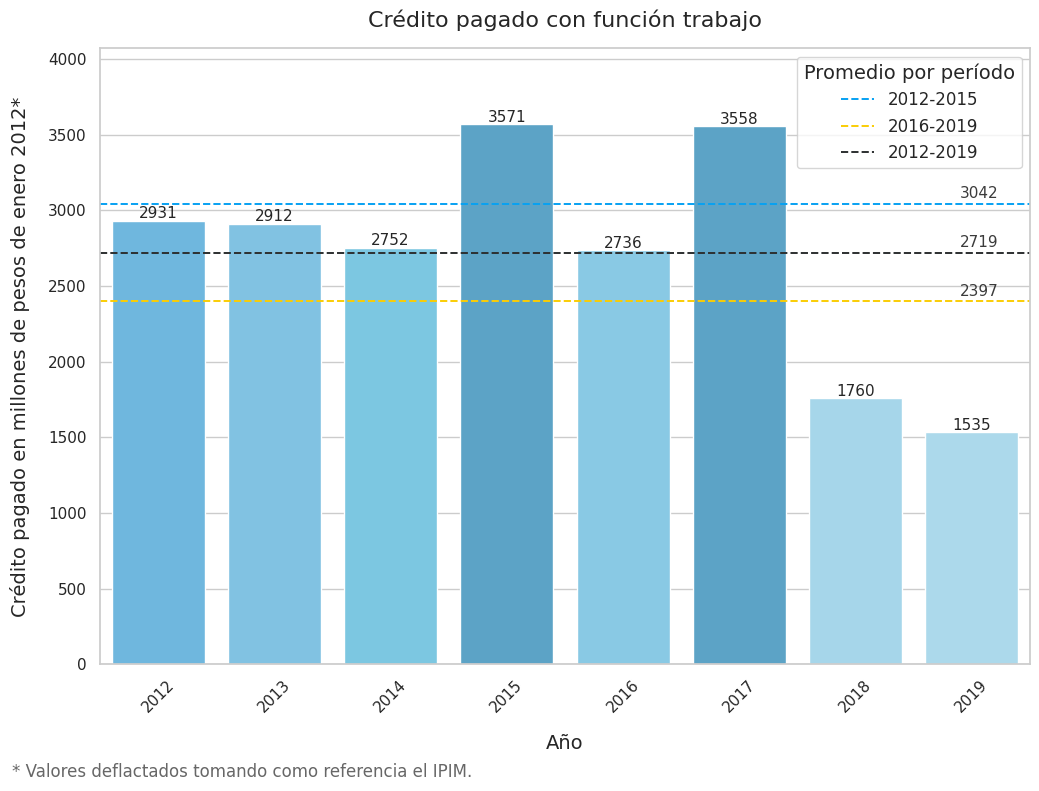

In [30]:
# Datos
años = list(total_pagado_trabajo_por_año.keys())
valores = list(total_pagado_trabajo_por_año.values())
periodos = list(promedio_por_periodo.keys())
promedios = list(promedio_por_periodo.values())

# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras
palette = ['#5dbdf0', '#71c8f2', '#6bcff2', '#4aa9d8',
           '#7acff3', '#4aa9d8', '#9bdbf5', '#a2ddf5']
ax = sns.barplot(x=años, y=valores, hue=años, legend=False, palette=palette)

# Configuración de etiquetas y título
ax.set_title('Crédito pagado con función trabajo',
             fontsize=16, pad=15)
ax.set_xlabel('Año', fontsize=14, labelpad=13)
ax.set_ylabel('Crédito pagado en millones de pesos de enero 2012*',
              fontsize=14, labelpad=13)
ax.set_xticks(range(len(años)))
ax.set_xticklabels(años, rotation=45)
ax.set_ylim(0, max(valores) + 500)

# Etiquetas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=11)


# Líneas punteadas para los períodos
colores = ['#07a1f2', '#facd05', '#2c2f30']
for i in range(len(promedios)):
    plt.axhline(promedios[i], color=colores[i], linestyle='--',
                linewidth=1.4, label=f'{periodos[i]}')
    plt.text(len(años) - 1.1, promedios[i] + 40,
             f'{promedios[i]:.0f}', fontsize=11, alpha=0.9)

# Añadir leyenda
ax.legend(loc='best', title="Promedio por período",
          title_fontsize='14', fontsize='12')

# Añadir disclaimer
plt.text(0.4, -0.175, '* Valores deflactados tomando como referencia el IPIM.',
         ha='right', va='center', transform=ax.transAxes, fontsize=12, alpha=0.7)

# Guardar y mostrar el gráfico
plt.savefig('plots/presupuesto/credito_pagado_funcion_trabajo.png',
            bbox_inches='tight')
plt.show()

### Gráfico de porcentaje de crédito pagado con función 'Trabajo' por año

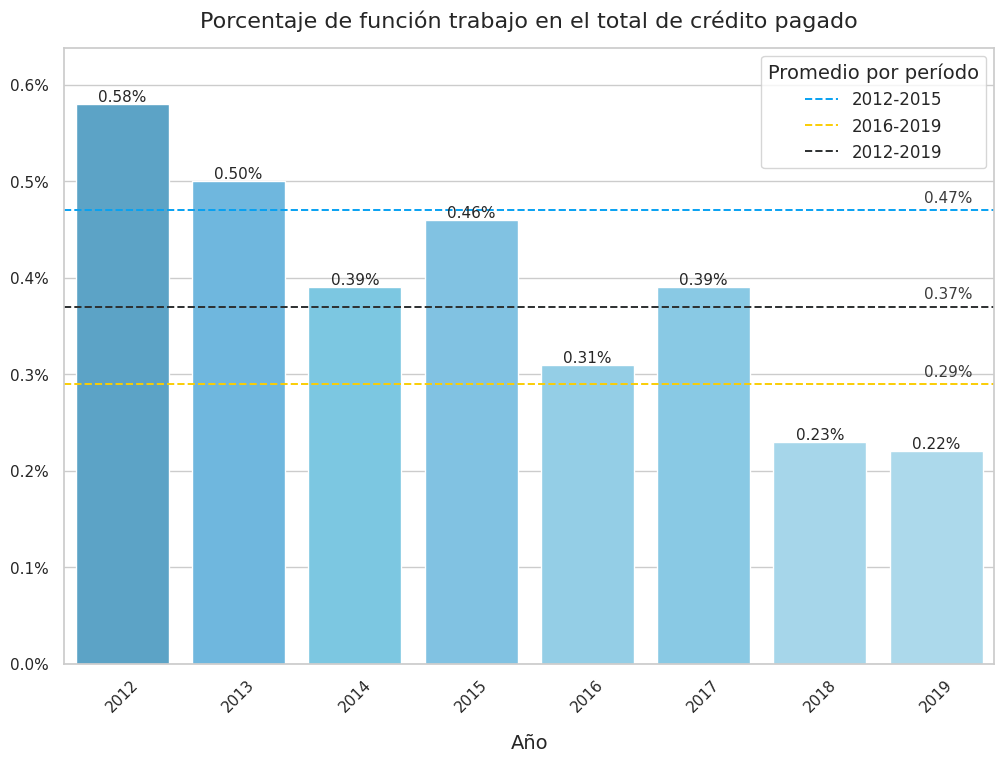

In [42]:
# Datos
años = list(porcentaje_por_año.keys())
porcentajes = list(porcentaje_por_año.values())
periodos = list(porcentaje_por_periodo.keys())
porcentajes_periodos = list(porcentaje_por_periodo.values())

# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras
palette = ['#4aa9d8', '#5dbdf0', '#6bcff2', '#71c8f2',
           '#86d4f4', '#7acff3', '#9bdbf5', '#a2ddf5']
ax = sns.barplot(x=años, y=porcentajes, hue=años,
                 legend=False, palette=palette)

# Configuración de etiquetas y título
ax.set_xlabel('Año', fontsize=14, labelpad=13)
ax.set_title('Porcentaje de función trabajo en el total de crédito pagado',
             fontsize=16, pad=15)
ax.set_xticks(range(len(años)))
ax.set_xticklabels(años, rotation=45, fontsize=11)
ax.set_ylim(0, max(porcentajes) * 1.1)

# Formatear el eje y como porcentaje
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
ax.yaxis.set_tick_params(pad=0.05, size=11)

# Etiquetas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=11)

# Líneas punteadas para los períodos
colores = ['#07a1f2', '#facd05', '#2c2f30']
for i in range(len(periodos)):
    plt.axhline(porcentajes_periodos[i], color=colores[i], linestyle='--',
                linewidth=1.4, label=f'{periodos[i]}')
    plt.text(len(años) - 1.1, porcentajes_periodos[i] + 0.008, f'{
             porcentajes_periodos[i]}%', fontsize=11, alpha=0.9)

# Añadir leyenda
ax.legend(loc='best', title="Promedio por período",
          title_fontsize='14', fontsize='12')

# Guardar y mostrar el gráfico
plt.savefig('plots/presupuesto/porcentaje_credito_pagado_funcion_trabajo.png',
            bbox_inches='tight')
plt.show()